# The ML Pipeline for a Model to Predict Length of Hospital Delivery Stay

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
from math import ceil
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import PredefinedSplit

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Gather Data

In [2]:
# specifying data types for the columns to maintain formatting from original data
data_types = {
    'hospital_service_area': object, 
    'hospital_county': object,
    'operating_certificate_number': object, 
    'permanent_facility_id': object,
    'facility_name': object, 
    'age_group': object, 
    'zip_code_3_digits': object, 
    'gender': object, 
    'race': object,
    'ethnicity': object, 
    'payment_typology_1': object, 
    'payment_typology_2': object,
    'payment_typology_3': object, 
    'length_of_stay': int
}

In [3]:
all_visits = pd.read_csv('../data/planned_deliveries.csv', dtype=data_types)
all_visits = all_visits.loc[:, all_visits.columns != 'Unnamed: 0']
y = all_visits['length_of_stay']
X = all_visits.loc[:, all_visits.columns != 'length_of_stay']

## Removing Highly Correlated Features to Help with Interpretability Later
See EDA.

In [4]:
X = X.loc[:, X.columns != 'operating_certificate_number']
X = X.loc[:, X.columns != 'facility_name']

# Split, Train, and Cross Validate - RMSE Evaluation Metric

In [5]:
def stratified_continuous_split(X:pd.DataFrame, y:pd.Series, train_size:float, val_size:float, test_size:float, random_state:int):
    '''
    Performs a stratified split of inputted data (with respect to y) into a training set, validation set, and test set to specified percentages 
    of the data using verstack's scsplit and performs basic error checking.

    Parameters:
    - X: a 2D pandas DataFrame, the feature matrix
    - y: a 1D pandas Series, the target variable matrix matching X
    - train_size: a float between 0 and 1, the percentage of X which should be training data
    - val_size: a float between 0 and 1, the percentage of X which should be reserved for validation
    - test_size: a float between 0 and 1, the percentage of X which should be reserved for final testing
    - random_state: an int, the random state to split with
    Note: The sum of train_size + val_size + test_size must be 1.0 (100% of X).

    Returns:
    - (X_train) a 2D pandas DataFrame, the feature matrix of training data
    - (y_train) a 1D pandas Series, the target variable matrix for training data
    - (X_val) a 2D pandas DataFrame, the feature matrix of validation data
    - (y_val) a 1D pandas Series, the target variable matrix for validation data
    - (X_test) a 2D pandas DataFrame, the feature matrix of testing data
    - (y_test) a 1D pandas Series, the target variable matrix for testing data

    Raises:
    - ValueError for invalid input
    '''
    from verstack.stratified_continuous_split import scsplit
    
    if ((train_size + val_size + test_size) != 1):
        raise ValueError('Your train_size + val_size + test_size must add up to 1 (100%)!')
    if (not isinstance(random_state, int)):
        raise ValueError('Your random_state must be an int!')

    X_train, X_other, y_train, y_other = scsplit(X, y, stratify=y, test_size=(1-train_size), random_state=random_state)
    
    X_len = X.shape[0]
    test_percent_of_other = (test_size * X_len)/(X_len - (train_size * X_len))
    X_other = X_other.reset_index(drop=True)
    y_other = y_other.reset_index(drop=True)
    
    X_val, X_test, y_val, y_test = scsplit(X_other, y_other, stratify=y_other, test_size=test_percent_of_other, random_state=random_state)

    # basic error checking to check that split returned train, val, and test of expected sizes
    train_count_low = (int)(train_size * X_len)
    train_count_high = ceil(train_size * X_len)
    val_count_low = (int)(val_size * X_len)
    val_count_high = ceil(val_size * X_len)
    test_count_low = (int)(test_size * X_len)
    test_count_high = ceil(test_size * X_len)
    
    Xtrain_fin = X_train.shape[0]
    ytrain_fin = y_train.shape[0]
    Xval_fin = X_val.shape[0]
    yval_fin = y_val.shape[0]
    Xtest_fin = X_test.shape[0]
    ytest_fin = y_test.shape[0]
    
    if not (((Xtrain_fin == train_count_low) or (Xtrain_fin == train_count_high)) and ((ytrain_fin == train_count_low) or (ytrain_fin == train_count_high))):
        raise ValueError(f'Training set size should be approx. {train_size * X_len}, instead is: {X_train.shape[0]}')
    if not (((Xval_fin == val_count_low) or (Xval_fin == val_count_high)) and ((yval_fin == val_count_low) or (yval_fin == val_count_high))):
        raise ValueError(f'Validation set size should be approx. {val_size * X_len}, instead is: {X_val.shape[0]}')
    if not (((Xtest_fin == test_count_low) or (Xtest_fin == test_count_high)) and ((ytest_fin == test_count_low) or (ytest_fin == test_count_high))):
        raise ValueError(f'Test set size should be approx. {test_size * X_len}, instead is: {X_test.shape[0]}')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
def unique_non_nans(X, ftr):
    '''
    Determines the unique, non-nan values of a certain feature in a feature matrix.
    Does not error check that ftr is in fact a column in X; this is the responsibility of the caller.
    
    - X: a 2D DataFrame feature matrix containing the feature of interest as a column
    - ftr: a string, the name of the feature to explore in X
    
    Returns:
    - (unique_vals_nonull) a list of the unique, non-null values of ftr in X, replacing a nan value with 'not reported'
    '''
    unique_vals = X[ftr].unique()
    unique_vals_nonull = ['not reported' if isinstance(x, float) and np.isnan(x) else x for x in unique_vals]

    return unique_vals_nonull    

In [7]:
random_state = 42

# categorizing the columns in my dataset by how they should be encoded
onehot_ftrs = ['hospital_service_area', 'hospital_county', 'permanent_facility_id', \
               'zip_code_3_digits', 'gender', 'race', 'ethnicity', 'payment_typology_1', \
               'payment_typology_2', 'payment_typology_3']
onehot_cats = [unique_non_nans(X, ftr) for ftr in onehot_ftrs]
ordinal_ftrs = ['age_group']
ordinal_cats = [['0 to 17', '18 to 29', '30 to 49', '50 to 69', '70 or Older']]

# replace missing values in categorical columns with 'not reported'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not reported')),
    ('onehot', OneHotEncoder(categories=onehot_cats, sparse=False, handle_unknown='ignore'))])

# my data has no missing values in its ordinal column, so only encoding is necessary
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', categorical_transformer, onehot_ftrs),
        ('ordinal', ordinal_transformer, ordinal_ftrs)])

### Checking Cross Validation Hyperparameter Ranges (1 random state)

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = stratified_continuous_split(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

# preprocess
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)
prep_1_ftrs = preprocessor.get_feature_names_out()
X_train_prep = pd.DataFrame(X_train_prep, columns=prep_1_ftrs)
X_val_prep = pd.DataFrame(X_val_prep, columns=prep_1_ftrs)
X_test_prep = pd.DataFrame(X_test_prep, columns=prep_1_ftrs)

# final preprocess with Standard Scaler so that I can use the coefficients of linear models as global importance metrics
standard_scaler_transformer = Pipeline(steps=[
    ('std', StandardScaler())])
final_preprocessor = ColumnTransformer(
    transformers=[('std', standard_scaler_transformer, preprocessor.get_feature_names_out())])

X_train_prep = final_preprocessor.fit_transform(X_train_prep)
X_val_prep = final_preprocessor.transform(X_val_prep)
X_test_prep = final_preprocessor.transform(X_test_prep)
prep_ftrs = final_preprocessor.get_feature_names_out()

### Baseline Performance

In [9]:
print('TRAINING:')
mean_length_of_stay = np.mean(y_train)
median_length_of_stay = np.median(y_train)
print('  Mean length of stay:', mean_length_of_stay)
print('  Median length of stay:', median_length_of_stay)
y_pred_mean = pd.Series([mean_length_of_stay]*len(y_train))
baseline_rmse = mean_squared_error(y_train, y_pred_mean, squared=False)
print('  Baseline RMSE [days]:', baseline_rmse)

print('VALIDATION:')
mean_length_of_stay = np.mean(y_val)
median_length_of_stay = np.median(y_val)
print('  Mean length of stay:', mean_length_of_stay)
print('  Median length of stay:', median_length_of_stay)
y_pred_mean = pd.Series([mean_length_of_stay]*len(y_val))
baseline_rmse = mean_squared_error(y_val, y_pred_mean, squared=False)
print('  Baseline RMSE [days]:', baseline_rmse)

TRAINING:
  Mean length of stay: 2.306417301896827
  Median length of stay: 2.0
  Baseline RMSE [days]: 0.9063444847636002
VALIDATION:
  Mean length of stay: 2.306833289018878
  Median length of stay: 2.0
  Baseline RMSE [days]: 0.9102089285787676


#### (1) Linear Regression with l1 Regularization

[1.00000000e-02 1.58489319e-02 2.51188643e-02 3.98107171e-02
 6.30957344e-02 1.00000000e-01 1.58489319e-01 2.51188643e-01
 3.98107171e-01 6.30957344e-01 1.00000000e+00 1.58489319e+00
 2.51188643e+00 3.98107171e+00 6.30957344e+00 1.00000000e+01
 1.58489319e+01 2.51188643e+01 3.98107171e+01 6.30957344e+01
 1.00000000e+02]


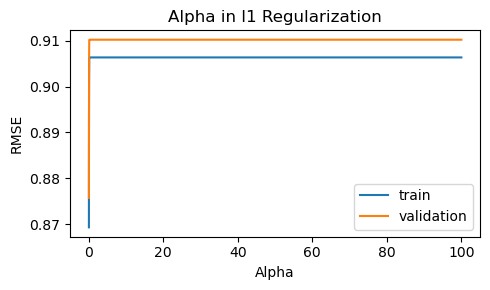

In [10]:
alphas = np.logspace(-2, 2, 21)
print(alphas)
train_scores = []
val_scores = []

for a in alphas:
    l1 = Lasso(random_state=random_state, alpha=a)
    l1.fit(X_train_prep, y_train)
    y_train_pred = l1.predict(X_train_prep)
    y_val_pred = l1.predict(X_val_prep)
    train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
    val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

plt.figure(figsize=(5, 3))
plt.plot(alphas, train_scores, label='train')
plt.plot(alphas, val_scores, label='validation')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Alpha in l1 Regularization')
plt.tight_layout()
plt.savefig('../figures/cv/l1_tuning_alpha.png', dpi=300, pad_inches=0.1)
plt.show()

#### (2) Linear Regression with l2 Regularization

[1.00000000e-02 1.58489319e-02 2.51188643e-02 3.98107171e-02
 6.30957344e-02 1.00000000e-01 1.58489319e-01 2.51188643e-01
 3.98107171e-01 6.30957344e-01 1.00000000e+00 1.58489319e+00
 2.51188643e+00 3.98107171e+00 6.30957344e+00 1.00000000e+01
 1.58489319e+01 2.51188643e+01 3.98107171e+01 6.30957344e+01
 1.00000000e+02]


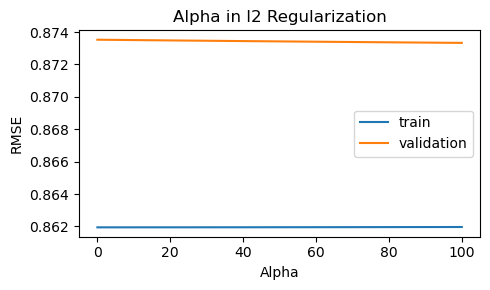

In [11]:
alphas = np.logspace(-2, 2, 21)
print(alphas)
train_scores = []
val_scores = []

for a in alphas:
    l2 = Ridge(random_state=random_state, alpha=a)
    l2.fit(X_train_prep, y_train)
    y_train_pred = l2.predict(X_train_prep)
    y_val_pred = l2.predict(X_val_prep)
    train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
    val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

plt.figure(figsize=(5, 3))
plt.plot(alphas, train_scores, label='train')
plt.plot(alphas, val_scores, label='validation')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Alpha in l2 Regularization')
plt.tight_layout()
plt.savefig('../figures/cv/l2_tuning_alpha.png', dpi=300, pad_inches=0.1)
plt.show()

#### (3) Linear Regression with Elastic Net Regularization

In [12]:
alphas = np.logspace(-2, 2, 21)
l1_ratios = np.linspace(0, 1, 21)
print(alphas)
print(l1_ratios)

for r in l1_ratios:
    train_scores = []
    val_scores = []
    for a in alphas:
        elastic = ElasticNet(random_state=random_state, alpha=a, l1_ratio=r)
        elastic.fit(X_train_prep, y_train)
        y_train_pred = elastic.predict(X_train_prep)
        y_val_pred = elastic.predict(X_val_prep)
        train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
        val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

    plt.figure(figsize=(5, 3))
    plt.plot(alphas, train_scores, label='train')
    plt.plot(alphas, val_scores, label='validation')
    plt.legend()
    plt.xlabel('Alpha')
    plt.ylabel('RMSE')
    plt.title(f'Alpha in ElasticNet Regularization (l1_ratio={int(r*100)/100})')
    plt.tight_layout()
    plt.savefig(f'../figures/cv/elastic_tuning_alpha_(l1_perc_{int(r*100)}).png', dpi=300, pad_inches=0.1)
    plt.show()

[1.00000000e-02 1.58489319e-02 2.51188643e-02 3.98107171e-02
 6.30957344e-02 1.00000000e-01 1.58489319e-01 2.51188643e-01
 3.98107171e-01 6.30957344e-01 1.00000000e+00 1.58489319e+00
 2.51188643e+00 3.98107171e+00 6.30957344e+00 1.00000000e+01
 1.58489319e+01 2.51188643e+01 3.98107171e+01 6.30957344e+01
 1.00000000e+02]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


KeyboardInterrupt: 

#### (4) Random Forest Regressor

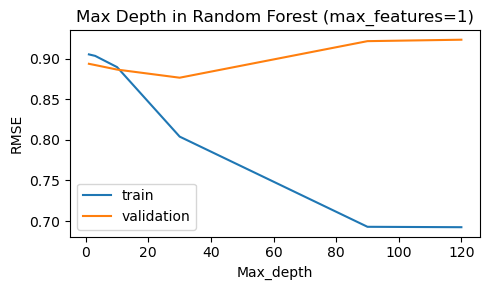

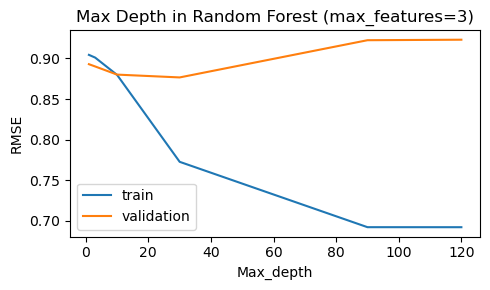

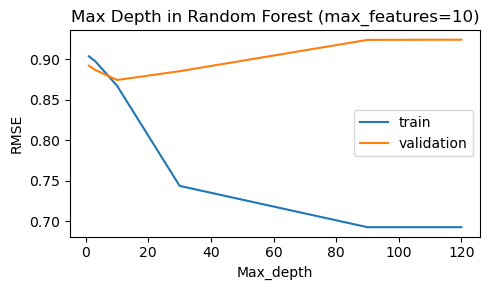

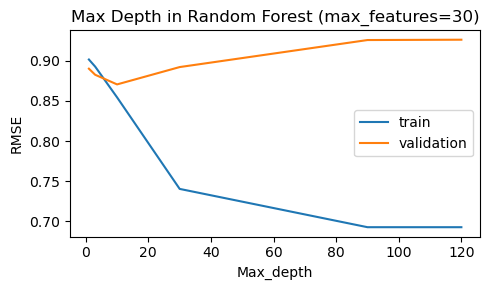

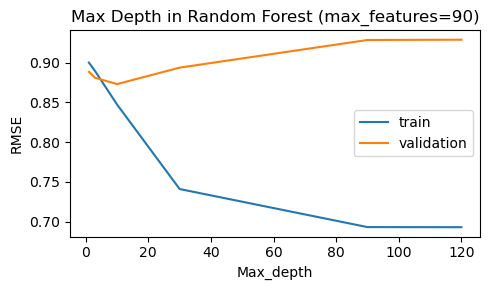

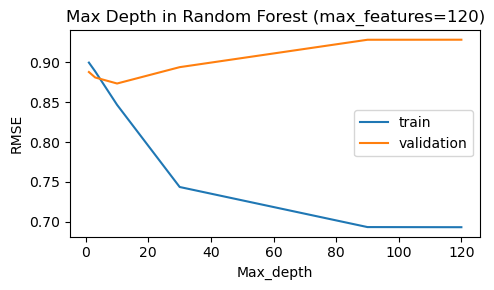

In [13]:
max_features = [1, 3, 10, 30, 90, 120]
max_depths = [1, 3, 10, 30, 90, 120]

for f in max_features:
    train_scores = []
    val_scores = []
    for d in max_depths:
        rf = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=random_state, max_features=f, max_depth=d)
        rf.fit(X_train_prep, y_train)
        y_train_pred = rf.predict(X_train_prep)
        y_val_pred = rf.predict(X_val_prep)
        train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
        val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

    plt.figure(figsize=(5, 3))
    plt.plot(max_depths, train_scores, label='train')
    plt.plot(max_depths, val_scores, label='validation')
    plt.legend()
    plt.xlabel('Max_depth')
    plt.ylabel('RMSE')
    plt.title(f'Max Depth in Random Forest (max_features={f})')
    plt.tight_layout()
    plt.savefig(f'../figures/cv/rf_tuning_max_depth_(max_ftrs_{f}).png', dpi=300, pad_inches=0.1)
    plt.show()

#### (5) Support Vector Regression (SVR)

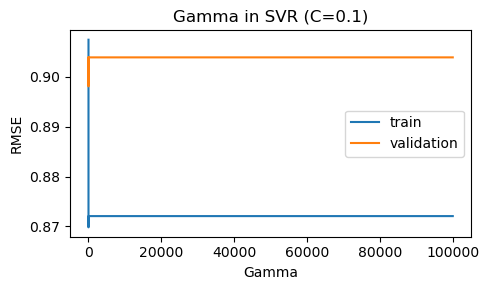

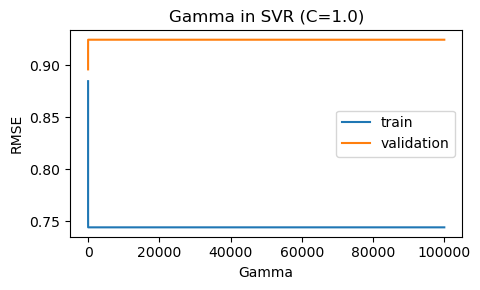

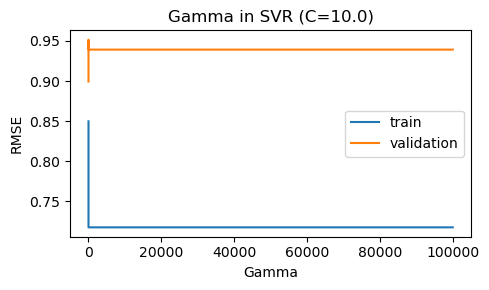

In [14]:
gammas = [1e-3, 1e-1, 1e1, 1e3, 1e5]
cs = [1e-1, 1e0, 1e1]

for c in cs:
    train_scores = []
    val_scores = []
    for g in gammas:
        svr = SVR(gamma=g, C=c)
        svr.fit(X_train_prep, y_train)
        y_train_pred = svr.predict(X_train_prep)
        y_val_pred = svr.predict(X_val_prep)
        train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
        val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

    plt.figure(figsize=(5, 3))
    plt.plot(gammas, train_scores, label='train')
    plt.plot(gammas, val_scores, label='validation')
    plt.legend()
    plt.xlabel('Gamma')
    plt.ylabel('RMSE')
    plt.title(f'Gamma in SVR (C={c})')
    plt.tight_layout()
    plt.savefig(f'../figures/cv/svr_tuning_gamma_(C_{c}).png', dpi=300, pad_inches=0.1)
    plt.show()

### Set up functions for automated pipeline (multiple iterations with multiple random states)

In [8]:
def MLpipe_Stratified_Continous_RMSE(X, y, preprocessor, ML_algo, param_grid, xgb=False):
    '''
    This function splits the data to train, validation, and test (60/20/20).
    The RMSE is minimized in cross-validation.
    
    This function:
    1. Loops through 10 different random states
    2. Splits the data 60/20/20.
    3. Fits a model with the predefined Preprocessor, trains the model with each hyperparameter combination in param_grid
    4. Calculates the model's error on the test set on the model with the best hyperparameter combinations in param_grid
    5. Returns a list of 10 test scores and 10 best models

    Arguments:
    - X: a 2D pandas DataFrame, the raw (not preprocessed) feature matrix
    - y: a 1D pandas Series, the raw (not preprocessed) target variable matrix matching X
    - preprocessor: a ColumnTransformer to use for preprocessing X
    - ML_algo: an initialized supervised machine learning algorithm;
               currently supports linear regression, random forest regression, SVR, and XGBoost regressor models
    - param_grid: a dictionary matching ML_algo parameters to a list of values to try in hyperparameter tuning,
                  keys must be formatted with prefix of the algorithm's name followed by two underscores
    - xgb: a boolean with default value False, if the ML model is an XGBoost model or not

    Returns:
    - (test_scores) a list of the 10 best models' test scores (1 for each random state)
    - (best_models) a list of the 10 best models of type ML_algo (1 for each random state)
    - (test_Xs) a list of the 10 DataFrames of test feature matricies corresponding to the test scores returned
    - (test_ys) a list of the 10 Series of true target variable values corresponding to the test scores returned
    '''
    
    # lists to be returned
    test_scores = []
    best_models = []
    train_Xs = []
    train_ys = []
    val_Xs = []
    val_ys = []
    test_Xs = []
    test_ys = []

    nr_states = 10
    for i in range(nr_states):
        rs = 42 * i
        print('Random State:', rs)

        # split
        X_train, y_train, X_val, y_val, X_test, y_test = stratified_continuous_split(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=rs)

        # preprocess
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)
        X_test_prep = preprocessor.transform(X_test)
        prep_1_ftrs = preprocessor.get_feature_names_out()
        X_train_prep = pd.DataFrame(X_train_prep, columns=prep_1_ftrs)
        X_val_prep = pd.DataFrame(X_val_prep, columns=prep_1_ftrs)
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_1_ftrs)

        # final preprocess with Standard Scaler so that I can use the coefficients of linear models as global importance metrics
        standard_scaler_transformer = Pipeline(steps=[
            ('std', StandardScaler())])
        final_preprocessor = ColumnTransformer(
            transformers=[('std', standard_scaler_transformer, preprocessor.get_feature_names_out())])
        
        X_train_prep = final_preprocessor.fit_transform(X_train_prep)
        X_val_prep = final_preprocessor.transform(X_val_prep)
        X_test_prep = final_preprocessor.transform(X_test_prep)

        # train and perform cross-validation        
        models = []
        val_scores = []
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            ML_algo.set_params(**params, random_state=rs) ####### LOOK HERE!!!!!!!!!!!!!!!!!!!!!!!!
            if (xgb):
                clf = ML_algo.fit(X_train_prep, y_train, early_stopping_rounds=50, eval_set=[(X_val_prep, y_val)], verbose=False)
            else:
                clf = ML_algo.fit(X_train_prep, y_train)
            models.append(clf)
            y_val_pred = clf.predict(X_val_prep)
            val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

        # save results
        print('    Best Model Parameters:', ParameterGrid(param_grid)[np.argmin(val_scores)])
        print('    Validation Set RMSE:', np.min(val_scores))
        best_model_this_rs = models[np.argmin(val_scores)]
        best_models.append(best_model_this_rs)
        y_test_pred = best_model_this_rs.predict(X_test_prep)
        test_score = mean_squared_error(y_test, y_test_pred, squared=False)
        test_scores.append(test_score)
        mean_length_of_stay = np.mean(y_test)
        print('    Baseline RMSE (test set):', mean_squared_error(y_test, pd.Series([mean_length_of_stay]*len(y_test))))
        print('    Test RMSE:', test_score)

        prep_ftrs = final_preprocessor.get_feature_names_out()
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_ftrs)
        test_Xs.append(X_test_prep)
        test_ys.append(y_test)
        X_train_prep = pd.DataFrame(X_train_prep, columns=prep_ftrs)
        train_Xs.append(X_train_prep)
        train_ys.append(y_train)
        X_val_prep = pd.DataFrame(X_val_prep, columns=prep_ftrs)
        val_Xs.append(X_val_prep)
        val_ys.append(y_val)
    
    return test_scores, best_models, prep_ftrs, test_Xs, test_ys, train_Xs, train_ys, val_Xs, val_ys

In [9]:
def MLpipe_Stratified_Continous_RMSE_no_rs(X, y, preprocessor, ML_algo, param_grid, xgb=False):
    '''
    This function splits the data to train, validation, and test (60/20/20).
    The RMSE is minimized in cross-validation.
    
    This function:
    1. Loops through 10 different random states
    2. Splits the data 60/20/20.
    3. Fits a model with the predefined Preprocessor, trains the model with each hyperparameter combination in param_grid
    4. Calculates the model's error on the test set on the model with the best hyperparameter combinations in param_grid
    5. Returns a list of 10 test scores and 10 best models

    Arguments:
    - X: a 2D pandas DataFrame, the raw (not preprocessed) feature matrix
    - y: a 1D pandas Series, the raw (not preprocessed) target variable matrix matching X
    - preprocessor: a ColumnTransformer to use for preprocessing X
    - ML_algo: an initialized supervised machine learning algorithm;
               currently supports linear regression, random forest regression, SVR, and XGBoost regressor models
    - param_grid: a dictionary matching ML_algo parameters to a list of values to try in hyperparameter tuning,
                  keys must be formatted with prefix of the algorithm's name followed by two underscores
    - xgb: a boolean with default value False, if the ML model is an XGBoost model or not

    Returns:
    - (test_scores) a list of the 10 best models' test scores (1 for each random state)
    - (best_models) a list of the 10 best models of type ML_algo (1 for each random state)
    - (test_Xs) a list of the 10 DataFrames of test feature matricies corresponding to the test scores returned
    - (test_ys) a list of the 10 Series of true target variable values corresponding to the test scores returned
    '''
    
    # lists to be returned
    test_scores = []
    best_models = []
    train_Xs = []
    train_ys = []
    val_Xs = []
    val_ys = []
    test_Xs = []
    test_ys = []

    nr_states = 10
    for i in range(nr_states):
        rs = 42 * i
        print('Random State:', rs)

        # split
        X_train, y_train, X_val, y_val, X_test, y_test = stratified_continuous_split(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=rs)

        # preprocess
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)
        X_test_prep = preprocessor.transform(X_test)
        prep_1_ftrs = preprocessor.get_feature_names_out()
        X_train_prep = pd.DataFrame(X_train_prep, columns=prep_1_ftrs)
        X_val_prep = pd.DataFrame(X_val_prep, columns=prep_1_ftrs)
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_1_ftrs)

        # final preprocess with Standard Scaler so that I can use the coefficients of linear models as global importance metrics
        standard_scaler_transformer = Pipeline(steps=[
            ('std', StandardScaler())])
        final_preprocessor = ColumnTransformer(
            transformers=[('std', standard_scaler_transformer, preprocessor.get_feature_names_out())])
        
        X_train_prep = final_preprocessor.fit_transform(X_train_prep)
        X_val_prep = final_preprocessor.transform(X_val_prep)
        X_test_prep = final_preprocessor.transform(X_test_prep)

        # train and perform cross-validation        
        models = []
        val_scores = []
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            ML_algo.set_params(**params) ####### LOOK HERE!!!!!!!!!!!!!!!!!!!!!!!!
            if (xgb):
                clf = ML_algo.fit(X_train_prep, y_train, early_stopping_rounds=50, eval_set=[(X_val_prep, y_val)], verbose=False)
            else:
                clf = ML_algo.fit(X_train_prep, y_train)
            models.append(clf)
            y_val_pred = clf.predict(X_val_prep)
            val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

        # save results
        print('    Best Model Parameters:', ParameterGrid(param_grid)[np.argmin(val_scores)])
        print('    Validation Set RMSE:', np.min(val_scores))
        best_model_this_rs = models[np.argmin(val_scores)]
        best_models.append(best_model_this_rs)
        y_test_pred = best_model_this_rs.predict(X_test_prep)
        test_score = mean_squared_error(y_test, y_test_pred, squared=False)
        test_scores.append(test_score)
        mean_length_of_stay = np.mean(y_test)
        print('    Baseline RMSE (test set):', mean_squared_error(y_test, pd.Series([mean_length_of_stay]*len(y_test))))
        print('    Test RMSE:', test_score)

        prep_ftrs = final_preprocessor.get_feature_names_out()
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_ftrs)
        test_Xs.append(X_test_prep)
        test_ys.append(y_test)
        X_train_prep = pd.DataFrame(X_train_prep, columns=prep_ftrs)
        train_Xs.append(X_train_prep)
        train_ys.append(y_train)
        X_val_prep = pd.DataFrame(X_val_prep, columns=prep_ftrs)
        val_Xs.append(X_val_prep)
        val_ys.append(y_val)
    
    return test_scores, best_models, prep_ftrs, test_Xs, test_ys, train_Xs, train_ys, val_Xs, val_ys

### Run and Cross Validate Several Models - RMSE

In [10]:
random_state = 42

# categorizing the columns in my dataset by how they should be encoded
onehot_ftrs = ['hospital_service_area', 'hospital_county', 'permanent_facility_id', \
               'zip_code_3_digits', 'gender', 'race', 'ethnicity', 'payment_typology_1', \
               'payment_typology_2', 'payment_typology_3']
onehot_cats = [unique_non_nans(X, ftr) for ftr in onehot_ftrs]
ordinal_ftrs = ['age_group']
ordinal_cats = [['0 to 17', '18 to 29', '30 to 49', '50 to 69', '70 or Older']]

# replace missing values in categorical columns with 'not reported'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not reported')),
    ('onehot', OneHotEncoder(categories=onehot_cats, sparse=False, handle_unknown='ignore'))])

# my data has no missing values in its ordinal column, so only encoding is necessary
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', categorical_transformer, onehot_ftrs),
        ('ordinal', ordinal_transformer, ordinal_ftrs)])

In [11]:
# keeping track of scores
models_rmses = pd.DataFrame(columns=['RMSE', 'l1', 'l2', 'Elastic Net', 'Random Forest Regressor', 'SVR', 'XGBoost Regressor'])
models_rmses['RMSE'] = pd.Series(['mean', 'std dev'])
models_rmses = models_rmses.set_index('RMSE')

#### (1) Linear Regression with l1 Regularization

In [12]:
lin_reg_l1 = Lasso(random_state=random_state)
l1_params = {
    'alpha': np.logspace(-2, 2, 21)
}
l1_test_scores, l1_best_models, prep_ftrs, l1_test_Xs, l1_test_ys, l1_train_Xs, l1_train_ys, l1_val_Xs, l1_val_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=lin_reg_l1, param_grid=l1_params)

Random State: 0
    Best Model Parameters: {'alpha': 0.01}
    Validation Set RMSE: 0.8504321989142208
    Baseline RMSE (test set): 0.8553764934213005
    Test RMSE: 0.9248671464111832
Random State: 42
    Best Model Parameters: {'alpha': 0.01}
    Validation Set RMSE: 0.8757083276046499
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.8787284379916777
Random State: 84
    Best Model Parameters: {'alpha': 0.01}
    Validation Set RMSE: 0.8577423755210356
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8943724758747483
Random State: 126
    Best Model Parameters: {'alpha': 0.01}
    Validation Set RMSE: 0.872251823429656
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.8787288027989463
Random State: 168
    Best Model Parameters: {'alpha': 0.01}
    Validation Set RMSE: 0.8470940019894443
    Baseline RMSE (test set): 0.8316709344515328
    Test RMSE: 0.9119600361292256
Random State: 210
    Best Model Parameters: {'alpha': 0.01}
    

In [13]:
print('****Metrics with l1 Linear Regression:****')
mean = np.mean(l1_test_scores)
std = np.std(l1_test_scores)
models_rmses['l1']['mean'] = mean
models_rmses['l1']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with l1 Linear Regression:****
Mean RMSE: 0.8974183815326736
Std. Deviation of RMSE: 0.014661023423358257


In [14]:
file = open('../results/lin_reg_l1.save', 'wb')
best_model_index = np.argmin(l1_test_scores)
pickle.dump((l1_best_models[best_model_index], l1_test_Xs[best_model_index], l1_test_ys[best_model_index], l1_train_Xs[best_model_index], l1_train_ys[best_model_index], l1_val_Xs[best_model_index], l1_val_ys[best_model_index]), file)
file.close()

#### (2) Linear Regression with l2 Regularization

In [15]:
lin_reg_l2 = Ridge(random_state=random_state)
l2_params = {
    'alpha': np.logspace(-2, 2, 21)
}
l2_test_scores, l2_best_models, prep_ftrs, l2_test_Xs, l2_test_ys, l2_train_Xs, l2_train_ys, l2_val_Xs, l2_val_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=lin_reg_l2, param_grid=l2_params)

Random State: 0
    Best Model Parameters: {'alpha': 100.0}
    Validation Set RMSE: 0.860707620848141
    Baseline RMSE (test set): 0.8031924223200353
    Test RMSE: 0.8695468144264233
Random State: 42
    Best Model Parameters: {'alpha': 100.0}
    Validation Set RMSE: 0.8733341853757849
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.8491589415014548
Random State: 84
    Best Model Parameters: {'alpha': 100.0}
    Validation Set RMSE: 0.8564939002156379
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8600689231364228
Random State: 126
    Best Model Parameters: {'alpha': 0.01}
    Validation Set RMSE: 0.8721371076461648
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.8457548593289326
Random State: 168
    Best Model Parameters: {'alpha': 100.0}
    Validation Set RMSE: 0.8485937177343478
    Baseline RMSE (test set): 0.8316709344515328
    Test RMSE: 0.8805774752888712
Random State: 210
    Best Model Parameters: {'alpha': 100.0}

In [16]:
print('****Metrics with l2 Linear Regression:****')
mean = np.mean(l2_test_scores)
std = np.std(l2_test_scores)
models_rmses['l2']['mean'] = mean
models_rmses['l2']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with l2 Linear Regression:****
Mean RMSE: 0.8637420367590547
Std. Deviation of RMSE: 0.011801943097049008


In [17]:
file = open('../results/lin_reg_l2.save', 'wb')
best_model_index = np.argmin(l2_test_scores)
pickle.dump((l2_best_models[best_model_index], l2_test_Xs[best_model_index], l2_test_ys[best_model_index], l2_train_Xs[best_model_index], l2_train_ys[best_model_index], l2_val_Xs[best_model_index], l2_val_ys[best_model_index]), file)
file.close()

#### (3) Linear Regression with Elastic Net Regularization

In [18]:
lin_reg_elastic = ElasticNet(random_state=random_state)
elastic_params = {
    'alpha': np.logspace(-2, 2, 21),
    'l1_ratio': np.linspace(0, 1, 21)
}
elastic_test_scores, elastic_best_models, prep_ftrs, elastic_test_Xs, elastic_test_ys, elastic_train_Xs, elastic_train_ys, elastic_val_Xs, elastic_val_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=lin_reg_elastic, param_grid=elastic_params)

Random State: 0
    Best Model Parameters: {'l1_ratio': 0.05, 'alpha': 0.06309573444801933}
    Validation Set RMSE: 0.859337943164916
    Baseline RMSE (test set): 0.8031924223200353
    Test RMSE: 0.8962118395762857
Random State: 42
    Best Model Parameters: {'l1_ratio': 0.0, 'alpha': 0.25118864315095807}
    Validation Set RMSE: 0.8720459602495433
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.8787284379916777
Random State: 84
    Best Model Parameters: {'l1_ratio': 0.4, 'alpha': 0.01}
    Validation Set RMSE: 0.8545831173047272
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8943724758747483
Random State: 126
    Best Model Parameters: {'l1_ratio': 0.5, 'alpha': 0.01}
    Validation Set RMSE: 0.8705824286869396
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.8787288027989463
Random State: 168
    Best Model Parameters: {'l1_ratio': 0.2, 'alpha': 0.025118864315095794}
    Validation Set RMSE: 0.8459813738306496
    Baseline RMS

In [19]:
print('****Metrics with Elastic Net Linear Regression:****')
mean = np.mean(elastic_test_scores)
std = np.std(elastic_test_scores)
models_rmses['Elastic Net']['mean'] = mean
models_rmses['Elastic Net']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with Elastic Net Linear Regression:****
Mean RMSE: 0.8945528508491838
Std. Deviation of RMSE: 0.01146893398428645


In [20]:
file = open('../results/lin_reg_elastic_net.save', 'wb')
best_model_index = np.argmin(elastic_test_scores)
pickle.dump((elastic_best_models[best_model_index], elastic_test_Xs[best_model_index], elastic_test_ys[best_model_index], elastic_train_Xs[best_model_index], elastic_train_ys[best_model_index], elastic_val_Xs[best_model_index], elastic_val_ys[best_model_index]), file)
file.close()

#### (4) Random Forest Regressor

In [21]:
random_forest_reg = RandomForestRegressor()
rf_params = {
    'n_jobs': [-1],
    'n_estimators': [100],
    'max_features': [1, 3, 10, 30, 90, 120],
    'max_depth': [1, 3, 10, 30, 90, 120]
}
rf_test_scores, rf_best_models, prep_ftrs, rf_test_Xs, rf_test_ys, rf_train_Xs, rf_train_ys, rf_val_Xs, rf_val_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=random_forest_reg, param_grid=rf_params)

Random State: 0
    Best Model Parameters: {'n_jobs': -1, 'n_estimators': 100, 'max_features': 30, 'max_depth': 10}
    Validation Set RMSE: 0.8694013417771543
    Baseline RMSE (test set): 0.8031924223200353
    Test RMSE: 0.9394795735607214
Random State: 42
    Best Model Parameters: {'n_jobs': -1, 'n_estimators': 100, 'max_features': 30, 'max_depth': 10}
    Validation Set RMSE: 0.8853482555932023
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.915843067149456
Random State: 84
    Best Model Parameters: {'n_jobs': -1, 'n_estimators': 100, 'max_features': 30, 'max_depth': 10}
    Validation Set RMSE: 0.8659622895117177
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.9230641925109863
Random State: 126
    Best Model Parameters: {'n_jobs': -1, 'n_estimators': 100, 'max_features': 30, 'max_depth': 10}
    Validation Set RMSE: 0.8791858645056636
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.9171635527979082
Random State: 168
    Bes

In [22]:
print('****Metrics with Random Forest Regression:****')
mean = np.mean(rf_test_scores)
std = np.std(rf_test_scores)
models_rmses['Random Forest Regressor']['mean'] = mean
models_rmses['Random Forest Regressor']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with Random Forest Regression:****
Mean RMSE: 0.9305347998224356
Std. Deviation of RMSE: 0.01347014778425577


In [23]:
file = open('../results/random_forest_regressor.save', 'wb')
best_model_index = np.argmin(rf_test_scores)
pickle.dump((rf_best_models[best_model_index], rf_test_Xs[best_model_index], rf_test_ys[best_model_index], rf_train_Xs[best_model_index], rf_train_ys[best_model_index], rf_val_Xs[best_model_index], rf_val_ys[best_model_index]), file)
file.close()

#### (5) Support Vector Regression (SVR)

In [24]:
svr = SVR()
svr_params = {
    'gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
    'C': [1e-1, 1e0, 1e1]
}
svr_test_scores, svr_best_models, prep_ftrs, svr_test_Xs, svr_test_ys, svr_train_Xs, svr_train_ys, svr_val_Xs, svr_val_ys = MLpipe_Stratified_Continous_RMSE_no_rs(X, y, preprocessor=preprocessor, ML_algo=svr, param_grid=svr_params)

Random State: 0
    Best Model Parameters: {'gamma': 0.001, 'C': 1.0}
    Validation Set RMSE: 0.8876660928616424
    Baseline RMSE (test set): 0.8031924223200353
    Test RMSE: 0.9464227386162484
Random State: 42
    Best Model Parameters: {'gamma': 0.001, 'C': 1.0}
    Validation Set RMSE: 0.8984218809400567
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.9319496336105709
Random State: 84
    Best Model Parameters: {'gamma': 0.001, 'C': 1.0}
    Validation Set RMSE: 0.8790361239801019
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.9407572400454667
Random State: 126
    Best Model Parameters: {'gamma': 0.001, 'C': 1.0}
    Validation Set RMSE: 0.902142948375698
    Baseline RMSE (test set): 0.7721509063089668
    Test RMSE: 0.9291104336129802
Random State: 168
    Best Model Parameters: {'gamma': 0.001, 'C': 1.0}
    Validation Set RMSE: 0.8691625993632441
    Baseline RMSE (test set): 0.8316709344515328
    Test RMSE: 0.9651121069228878
Random Sta

In [25]:
print('****Metrics with Support Vector Regression:****')
mean = np.mean(svr_test_scores)
std = np.std(svr_test_scores)
models_rmses['SVR']['mean'] = mean
models_rmses['SVR']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with Support Vector Regression:****
Mean RMSE: 0.9462932299895511
Std. Deviation of RMSE: 0.015106992335290474


In [26]:
file = open('../results/svr.save', 'wb')
best_model_index = np.argmin(svr_test_scores)
pickle.dump((svr_best_models[best_model_index], svr_test_Xs[best_model_index], svr_test_ys[best_model_index], svr_train_Xs[best_model_index], svr_train_ys[best_model_index], svr_val_Xs[best_model_index], svr_val_ys[best_model_index]), file)
file.close()

#### (6) XGBoost

In [27]:
xgb = xgboost.XGBRegressor()
xgb_params = {
    'seed': [0],
    'n_estimators': [10000],
    'learning_rate': [0.03],
    'colsample_bytree': [0.9],
    'subsample': [0.66],
    'reg_alpha': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    'lambda': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    'max_depth': [1, 3, 10, 30, 100]
}
xgb_test_scores, xgb_best_models, prep_ftrs, xgb_test_Xs, xgb_test_ys, xgb_train_Xs, xgb_train_ys, xgb_val_Xs, xgb_val_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=xgb, param_grid=xgb_params, xgb=True)

Random State: 0
    Best Model Parameters: {'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'max_depth': 10, 'learning_rate': 0.03, 'lambda': 100.0, 'colsample_bytree': 0.9}
    Validation Set RMSE: 0.8451301421836529
    Baseline RMSE (test set): 0.8553764934213005
    Test RMSE: 0.8930443985769034
Random State: 42


KeyboardInterrupt: 

In [ ]:
print('****Metrics with XGB Regressor:****')
mean = np.mean(xgb_test_scores)
std = np.std(xgb_test_scores)
models_rmses['XGBoost Regressor']['mean'] = mean
models_rmses['XGBoost Regressor']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

In [ ]:
file = open('../results/xgboost.save', 'wb')
best_model_index = np.argmin(xgb_test_scores)
pickle.dump((xgb_best_models[best_model_index], xgb_test_Xs[best_model_index], xgb_test_ys[best_model_index], xgb_train_Xs[best_model_index], xgb_train_ys[best_model_index], xgb_val_Xs[best_model_index], xgb_val_ys[best_model_index]), file)
file.close()

### Results

In [28]:
models_rmses

,l1,l2,Elastic Net,Random Forest Regressor,SVR,XGBoost Regressor
RMSE,,,,,,
mean,0.897418,0.863742,0.894553,0.930535,0.946293,NaN
std dev,0.014661,0.011802,0.011469,0.01347,0.015107,NaN


# Best Model - Global Interpretability

### Ridge

In [29]:
l2_file = open('../results/lin_reg_l2.save', 'rb')
l2_model, X_test, y_test, X_train, y_train, X_val, y_val = pickle.load(l2_file)
l2_file.close()

In [30]:
# making tuples to keep feature and corresponding w together
ws = l2_model.coef_
ftr_abs_ws = []
for i in range(0, len(prep_ftrs)):
    ftr_abs_ws.append((prep_ftrs[i], np.abs(ws[i])))
    
# ranking features by the absolute value of their mean coefficient value (w)
sorted_ftrs = sorted(ftr_abs_ws, key=(lambda x: x[1]), reverse=True)
print('Top 10 most important features:')
for i in range(0, 10):
    print(f'{i+1}: {sorted_ftrs[i][0]}')

Top 10 most important features:
1: std__onehot__permanent_facility_id_001626
2: std__onehot__permanent_facility_id_000411
3: std__onehot__permanent_facility_id_001458
4: std__onehot__permanent_facility_id_000541
5: std__onehot__zip_code_3_digits_109
6: std__onehot__race_White
7: std__onehot__permanent_facility_id_001456
8: std__onehot__permanent_facility_id_000513
9: std__onehot__race_Black/African American
10: std__onehot__permanent_facility_id_000511


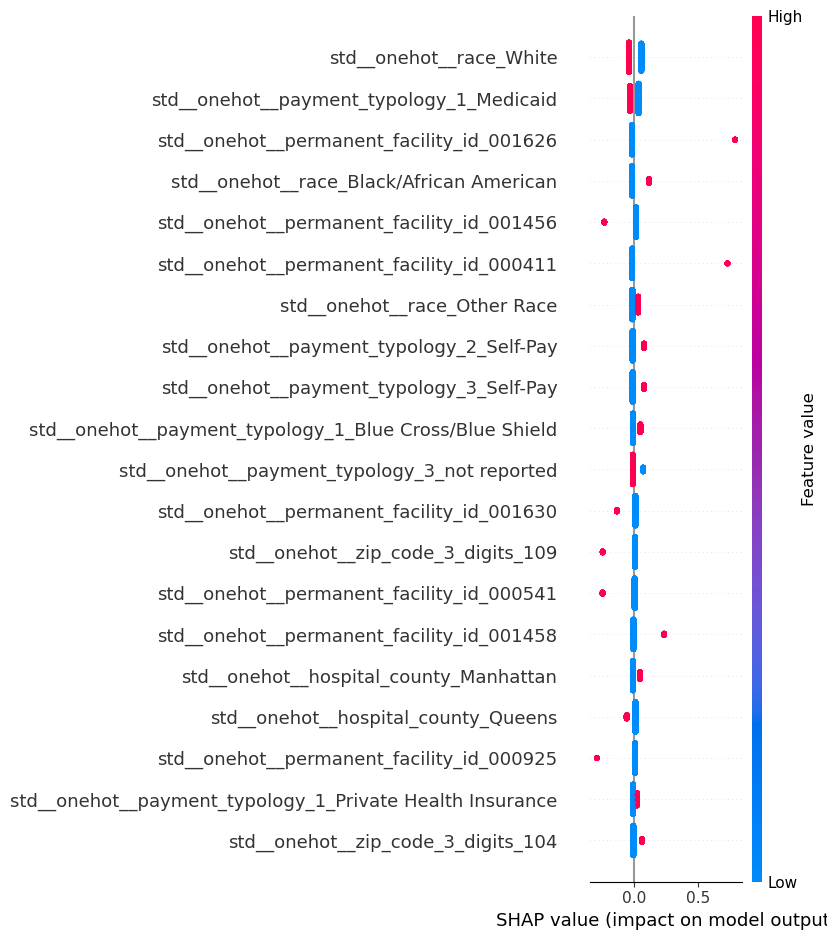

In [42]:
shap.initjs()
masker = shap.maskers.Independent(data=X_test)
explainer = shap.LinearExplainer(l2_model, masker=masker, algorithm='linear')
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=prep_ftrs)

### Random Forest Regressor (Experiment)

In [8]:
rf_file = open('../results/random_forest_regressor.save', 'rb')
rf_model, rf_X_test, rf_y_test, rf_X_train, rf_y_train, rf_X_val, rf_y_val = pickle.load(rf_file)
rf_file.close()

In [ ]:
shap.initjs()
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(rf_X_test)
shap.summary_plot(rf_shap_values, rf_X_test, feature_names=prep_ftrs)

# Best Model - Local Feature Importance (SHAP)

### Ridge

In [33]:
shap.initjs()
masker = shap.maskers.Independent(data=X_test)
explainer = shap.LinearExplainer(l2_model, masker=masker, algorithm='linear')
shap_values = explainer.shap_values(X_test.iloc[:2000, :])

In [34]:
index = 4
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)

In [35]:
index = 10
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)

In [36]:
index = 100
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)

In [37]:
index = 1386
shap.force_plot(explainer.expected_value, shap_values[index,:], features=X_test.iloc[index,:],feature_names=prep_ftrs)

### Random Forest Regressor (Experiment)

In [ ]:
shap.initjs()
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(rf_X_test.iloc[:1000, :])